In [1]:
import os
import sys
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import numpy as np
from tqdm import tqdm
import cv2
import wandb

In [10]:
wandb.login()
run = wandb.init(
    project='cancer-classifier-CNN-model-DL-course',
    config={}
    )

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from cancer_classifier.config import MODELS_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR, INTERIM_DATA_DIR, CLASSES
from cancer_classifier.processing.image_utils import adjust_image_contrast, resize_image_tensor, normalize_image_tensor, augment_image_tensor, process_dataset, save_processed_images, crop_image
from cancer_classifier.processing.dataset_loader import BrainTumorDataset, preprocess_images, unnormalize

%load_ext autoreload
%autoreload 2

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Data Preprocessing

### data crop and contract equilazing

In [13]:
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(RAW_DATA_DIR, cls)
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        img = crop_image(img_path)
        # img = adjust_image_contrast(img)

        # save in processed directory
        cv2.imwrite(os.path.join(INTERIM_DATA_DIR, cls, img_name), img)
        # save_processed_images(img_tensor, os.path.join(PROCESSED_DATA_DIR, cls), img_name)

In [14]:
img_size = (256, 256)
batch_nbr = 16
train_ratio = 0.80
test_ratio = 0.10
val_ratio = 0.10

### data augmentation

In [17]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize(size=img_size),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

Dataset = BrainTumorDataset(
    root_dir=PROCESSED_DATA_DIR,
    transform=transformers
)

print(Dataset.class_to_idx)

{'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}


### data spliting 

In [19]:
batch_nbr = 16
train_ratio = 0.80
test_ratio = 0.10
val_ratio = 0.10

train_loader, val_loader, test_loader = Dataset.get_dataloaders(
    batch_size=batch_nbr,
    train_ratio=train_ratio,
    val_ratio=val_ratio
)

# Model Architecture: CNN

In [20]:
def conv_block(out_channels, kernel_size=3,
                stride=1, padding=1, pool_kernel_size=2,
                pool_stride=2, dropout_prob=0.2):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=dropout_prob),
        nn.MaxPool2d(pool_kernel_size, pool_stride)
    )

In [21]:
fc_dropout_prob = 0.3
class CNNModel(nn.Module):
  def __init__(self, num_classes=CLASSES):
    super(CNNModel, self).__init__()
    
    self.conv_net = nn.Sequential(
        conv_block(64, 3),
        conv_block(128, 5),
        conv_block(256, 5),
        conv_block(512, 3, 2)  
    )
    
    self.fc_layers = nn.Sequential(
           nn.Dropout(fc_dropout_prob),
           nn.LazyLinear(512),
           nn.ReLU(inplace=True),
           nn.Linear(512, num_classes)
        )

  def forward(self, x):
    x = self.conv_net(x)

    x = torch.flatten(x, 1)

    x = self.fc_layers(x)

    return x


In [22]:
CNN_model = CNNModel(num_classes=len(CLASSES)).to(device)
# print(CNN_model)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def display_activations_side_by_side(activations, num_columns=6): #j'ai mis 6 car dans le cours on affiche 6 on peut changer
    """
    Displays the first `num_columns` feature-maps of a tensor `activations`
    
    activations : torch.Tensor de shape [1, n_filters, H, W]
    num_columns : nombre de feature-maps à afficher max
    """
    
    n_filters, H, W = activations.shape[1], activations.shape[2], activations.shape[3]
    n_cols = min(num_columns, n_filters)
    
    fig, axes = plt.subplots(1, n_cols, figsize=(n_cols*2, 2))
    
    for i in range(n_cols):
        fmap = activations[0, i].detach().cpu().numpy()
        ax = axes[i] if n_cols > 1 else axes
        ax.imshow(fmap, cmap='viridis')
        ax.set_title(f'FM {i}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    
def get_activation(model, block_idx, x):
    """Renvoie la sortie du conv_block #block_idx (0-based)."""
    blocks = [
        model.conv_block1,
        model.conv_block2,
        model.conv_block3,
        model.conv_block4
    ]
    out = x
    with torch.no_grad():
        for i in range(block_idx + 1):
            out = blocks[i](out)
    return out


Après conv_block1 :


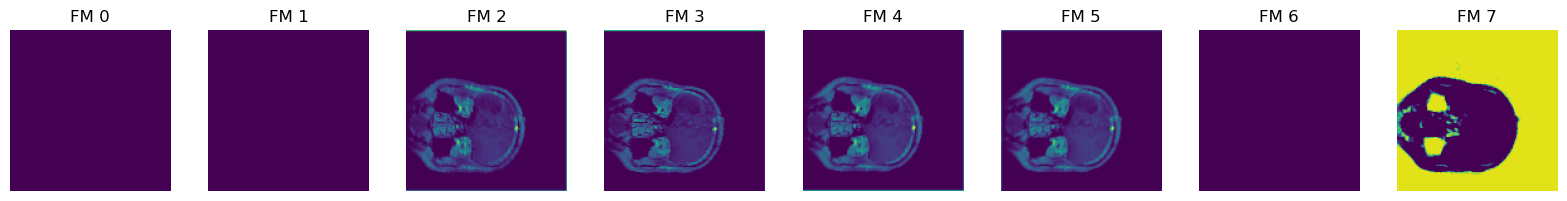

Après conv_block2 :


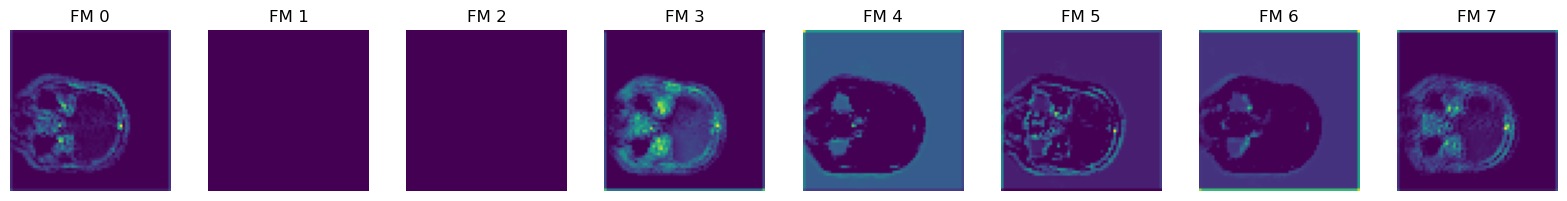

Après conv_block3 :


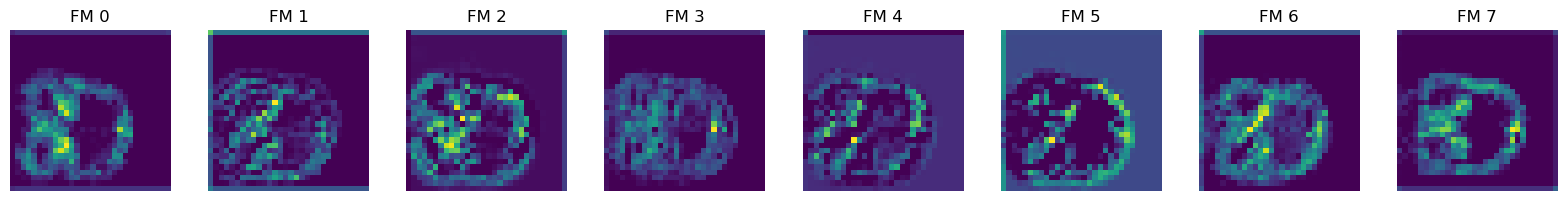

Après conv_block4 :


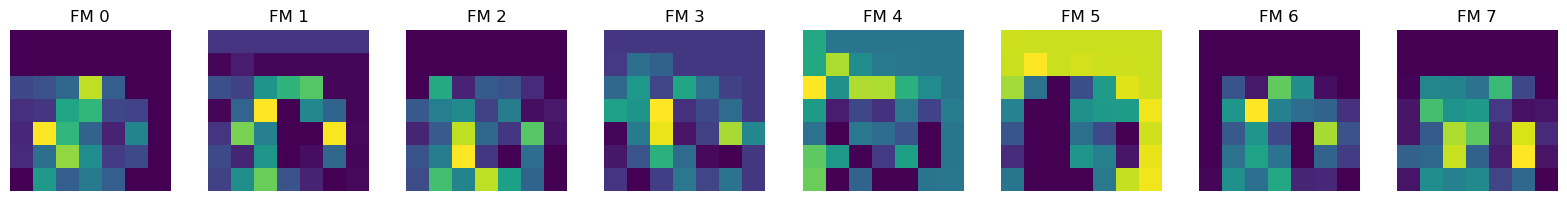

In [12]:
sample_img, _ = dataset[0]
x = sample_img.unsqueeze(0).to(device)

for idx in range(4):
    acts = get_activation(CNN_model, idx, x)
    print(f"Après conv_block{idx+1} :")
    display_activations_side_by_side(acts, num_columns=8)


## Training the model

### defining Loss function, Optimization method, and training parameters

In [23]:
loss_fn = nn.CrossEntropyLoss()
weights_decay = 0.0001
learning_rate = 0.0001
epochs = 10

# optimizer = torch.optim.Adam(
#     CNN_model.parameters(),
#     lr=learning_rate,
#     weight_decay=weights_decay
# ) #->70%

optimizer = torch.optim.AdamW(
    CNN_model.parameters(),
    lr=learning_rate,
    weight_decay=weights_decay
) #->77.4

# optimizer = torch.optim.SGD(
#     CNN_model.parameters(),
#     lr=learning_rate,
#     weight_decay=weights_decay
# ) #> 77.5

In [24]:
def test_loop(dataloader, model, loss_fn, epoch=0):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    true_labels = []
    pred_labels = []

    batch_losses = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(pred.argmax(1).cpu().numpy())
            batch_losses.append(test_loss)

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # wandb.log({"epoch": epoch,"accuracy": f"{(100*correct):>0.1f}", "test_loss": test_loss})

    return true_labels, pred_labels, correct, test_loss, batch_losses

In [25]:
from cancer_classifier.modeling.train import train
# import evaluate from cancer_classifier.modeling.evaluate as evaluate
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    batch_losses = [] 

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device) 
        pred = model(X)
        loss = loss_fn(pred, y)

        batch_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_nbr + len(X)
            # wandb.log({"step":  f"{current:>5d}/{size:>5d}", "train_loss": loss})
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return batch_losses


In [26]:
# Initialisation des listes pour stocker les losses
train_losses = []
test_losses  = []

for epoch in tqdm(range(epochs)):
    print("----------------- EPOCH " + str(epoch) + "------------------")
    train_batch_losses = train_loop(
        dataloader=train_loader,
        model=CNN_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        epoch=epoch
        )
    train_losses.extend(train_batch_losses)

    true_labels, pred_labels, correct, test_loss, test_batch_losses =  test_loop(
        dataloader=test_loader,
        model=CNN_model,
        loss_fn=loss_fn,
        epoch=epoch
    )

    test_losses.extend(test_batch_losses)


  0%|          | 0/10 [00:00<?, ?it/s]

----------------- EPOCH 0------------------
loss: 1.110819  [   16/ 4845]
loss: 0.529070  [ 1616/ 4845]
loss: 0.581987  [ 3216/ 4845]
loss: 0.413710  [ 4816/ 4845]


 10%|█         | 1/10 [01:02<09:19, 62.17s/it]

Test Error: 
 Accuracy: 77.5%, Avg loss: 0.534564 

----------------- EPOCH 1------------------
loss: 1.000294  [   16/ 4845]
loss: 0.772649  [ 1616/ 4845]
loss: 0.455937  [ 3216/ 4845]
loss: 0.296218  [ 4816/ 4845]


 20%|██        | 2/10 [01:31<05:43, 42.93s/it]

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.477183 

----------------- EPOCH 2------------------
loss: 0.456208  [   16/ 4845]
loss: 0.584988  [ 1616/ 4845]
loss: 0.692933  [ 3216/ 4845]
loss: 0.417727  [ 4816/ 4845]


 30%|███       | 3/10 [02:01<04:19, 37.03s/it]

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.388473 

----------------- EPOCH 3------------------
loss: 0.306135  [   16/ 4845]
loss: 0.417380  [ 1616/ 4845]
loss: 0.542023  [ 3216/ 4845]
loss: 0.430819  [ 4816/ 4845]


 40%|████      | 4/10 [02:30<03:21, 33.66s/it]

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.374927 

----------------- EPOCH 4------------------
loss: 0.379010  [   16/ 4845]
loss: 0.400424  [ 1616/ 4845]
loss: 0.293753  [ 3216/ 4845]
loss: 0.549402  [ 4816/ 4845]


 50%|█████     | 5/10 [02:58<02:39, 31.86s/it]

Test Error: 
 Accuracy: 88.6%, Avg loss: 0.308583 

----------------- EPOCH 5------------------
loss: 0.250249  [   16/ 4845]
loss: 0.458264  [ 1616/ 4845]
loss: 0.547858  [ 3216/ 4845]
loss: 0.190101  [ 4816/ 4845]


 60%|██████    | 6/10 [03:27<02:03, 30.83s/it]

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.273752 

----------------- EPOCH 6------------------
loss: 0.224538  [   16/ 4845]
loss: 0.240742  [ 1616/ 4845]
loss: 0.247297  [ 3216/ 4845]
loss: 0.344079  [ 4816/ 4845]


 70%|███████   | 7/10 [03:56<01:30, 30.12s/it]

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.246178 

----------------- EPOCH 7------------------
loss: 0.264118  [   16/ 4845]
loss: 0.354899  [ 1616/ 4845]
loss: 0.220937  [ 3216/ 4845]
loss: 0.513162  [ 4816/ 4845]


 80%|████████  | 8/10 [04:25<00:59, 29.86s/it]

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.197195 

----------------- EPOCH 8------------------
loss: 0.144446  [   16/ 4845]
loss: 0.165357  [ 1616/ 4845]
loss: 0.457361  [ 3216/ 4845]
loss: 0.147151  [ 4816/ 4845]


 90%|█████████ | 9/10 [04:54<00:29, 29.49s/it]

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.199143 

----------------- EPOCH 9------------------
loss: 0.059992  [   16/ 4845]
loss: 0.499679  [ 1616/ 4845]
loss: 0.470306  [ 3216/ 4845]
loss: 0.435335  [ 4816/ 4845]


100%|██████████| 10/10 [05:23<00:00, 32.37s/it]

Test Error: 
 Accuracy: 89.4%, Avg loss: 0.254244 



In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_curves(
    train_batch_losses: list[list[float]],
    test_batch_losses:  list[list[float]],
    labels:             list[str],
    batch_size:         int
):
    fig, (ax_tr, ax_te) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Training loss subplot
    for losses, name in zip(train_batch_losses, labels):
        x = np.arange(1, len(losses) + 1) * batch_size
        ax_tr.plot(x, losses, label=name)
    ax_tr.set_yscale('log')
    ax_tr.set_xlabel('Samples seen')
    ax_tr.set_ylabel('Loss')
    ax_tr.set_title('Training Loss')
    ax_tr.grid(which='both', linestyle='--', linewidth=0.5)
    ax_tr.legend(loc='upper right')

    # Test loss subplot
    for losses, name in zip(test_batch_losses, labels):
        x = np.arange(1, len(losses) + 1) * batch_size
        ax_te.plot(x, losses, label=name)
    ax_te.set_yscale('log')
    ax_te.set_xlabel('Samples seen')
    ax_te.set_title('Test Loss')
    ax_te.grid(which='both', linestyle='--', linewidth=0.5)
    ax_te.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


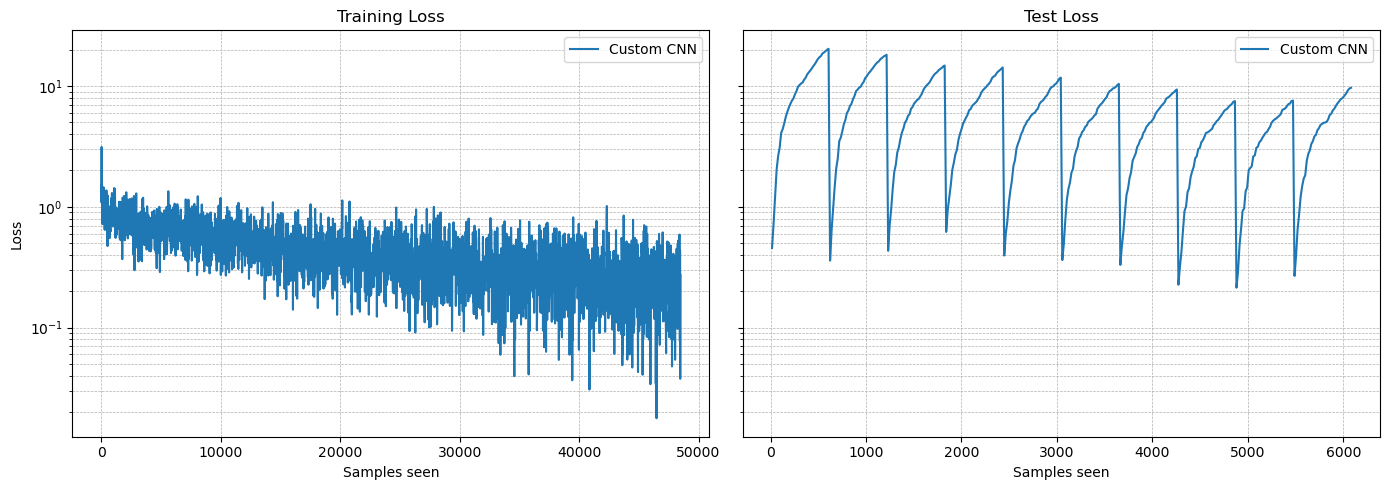

In [29]:

plot_loss_curves(
    train_batch_losses=[train_losses],
    test_batch_losses=[test_losses],
    labels=['Custom CNN'],
    batch_size=batch_nbr
)

## Evaluating the model

### Covariance Matrix

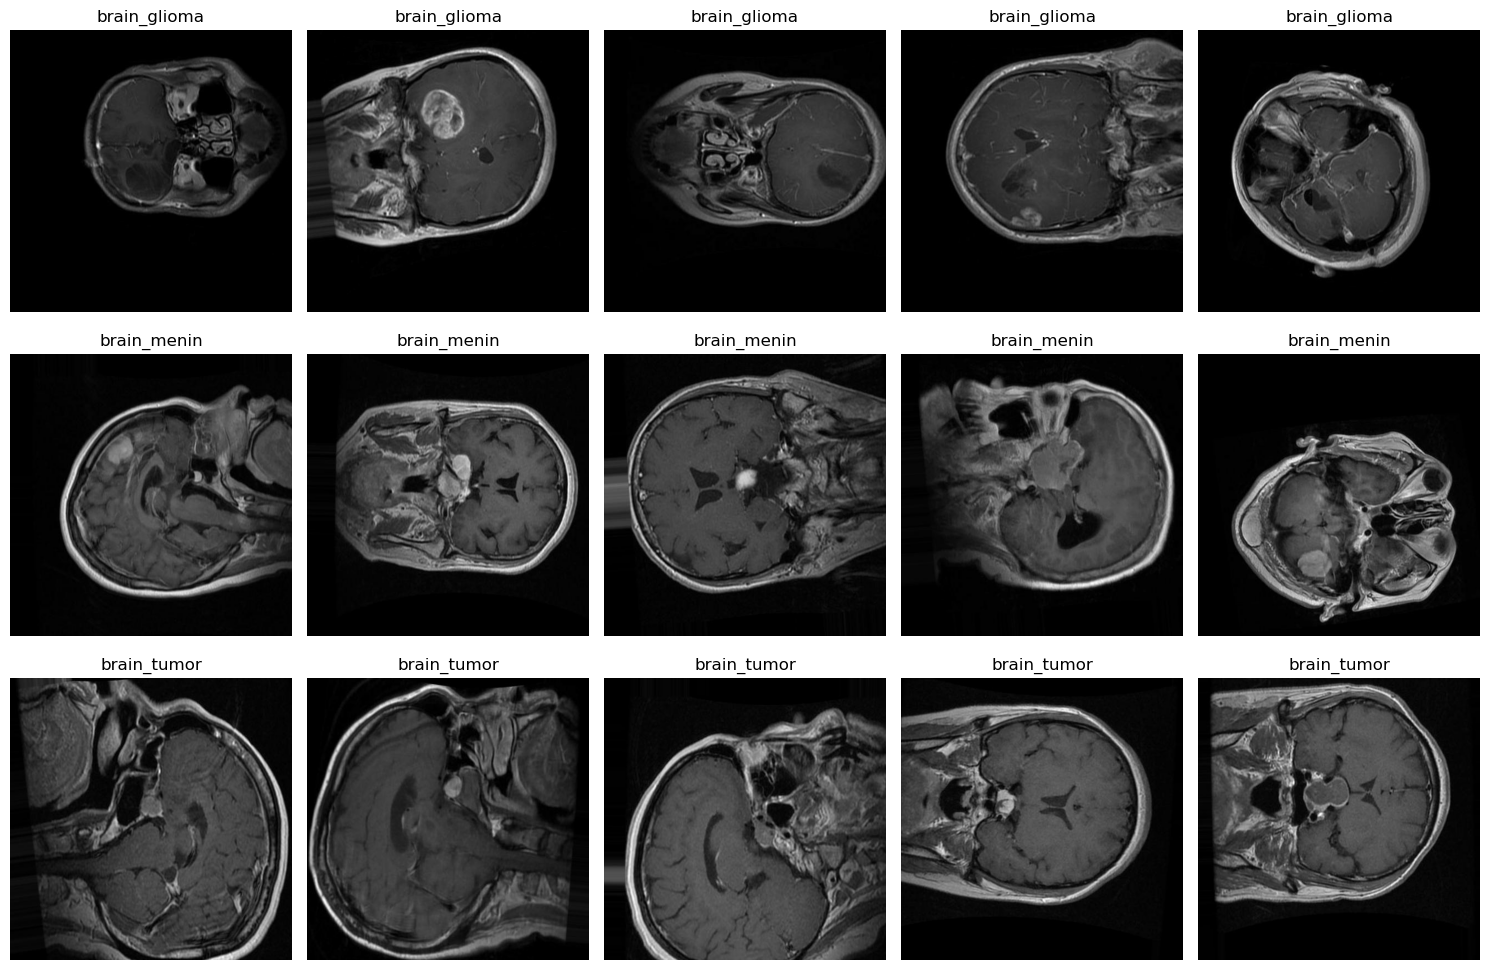

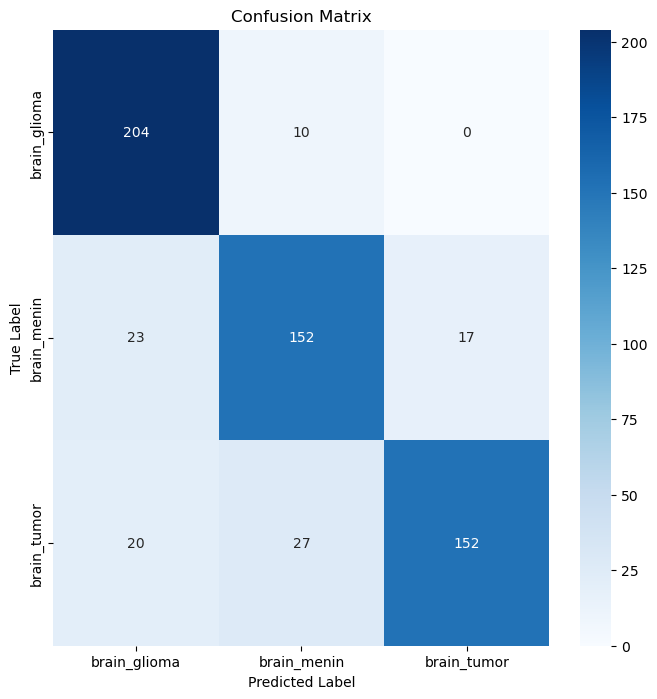

In [25]:
from cancer_classifier.plots import visualize_sample_images,  plot_confusion_matrix
import time

visualize_sample_images(
    dataset=dataset,
)
plot_confusion_matrix(
    true_classes=true_labels,
    predicted_classes=pred_labels,
    model_name =  time.strftime("%Y-%m-%d_%H-%M-%S") + "_CNN_model_" + f"{(100*correct):>0.1f}%"
)

### serializing the model

In [26]:
import time
model_name = f"{(100*correct):>0.1f}%--" + time.strftime("%Y-%m-%d_%H-%M-%S") + "_CNN_model.pth"
torch.save(CNN_model.state_dict(), MODELS_DIR / model_name)
print("Saved PyTorch Model State to " +  model_name)

Saved PyTorch Model State to 84.0%--2025-05-18_00-27-47_CNN_model.pth
